In [1]:
from NFDiffeo import Diffeo
from Hutils import simulate_trajectory, get_oscillator
from fit_archetype import fit_DFORM
from systems import DiffeoAug, SO, ComposeAug, Repressilator, BZreaction, Selkov, PhaseSpace, VanDerPol, LienardSigmoid
from matplotlib import pyplot as plt
import numpy as np
from typing import Callable
import pickle
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import torch
from copy import deepcopy

%load_ext autoreload
%autoreload 2
# %env

In [2]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'sans-serif',
    'figure.dpi': 90,
    'figure.autolayout': True,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'font.weight': 'bold',
    'font.size': 18,
    'axes.linewidth': 1.5,
    'axes.labelweight': 'bold',
    'lines.linewidth': 3,
    'legend.handlelength': 2.,
    'legend.handletextpad': .4,
    'legend.labelspacing': .0,
    'legend.borderpad': .4,
    'legend.fontsize': 13,
    'axes.edgecolor': '#303030',
    'savefig.facecolor': 'white',
    'text.latex.preamble': r'\usepackage{amsfonts}',
})

def plot_sys(system: PhaseSpace, lims):
    res = 64
    xx, yy = np.meshgrid(np.linspace(lims[0], lims[1], res), np.linspace(lims[0], lims[1]))
    xy = torch.from_numpy(np.stack([xx.flatten(), yy.flatten()]).T).float()
    uv = system.forward(0, xy).detach().cpu().numpy()
    uu, vv = uv[:, 0].reshape(xx.shape), uv[:, 1].reshape(yy.shape)
    c = np.sqrt(uu**2 + vv**2)
    plt.streamplot(xx, yy, uu, vv, density=1.5, color=c, cmap='gist_heat',
                   linewidth=1, maxlength=8)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

In [3]:
# def fit_DFORM(H: nn.Module, x: torch.Tensor, xdot: torch.Tensor, g: Callable, its: int=300, lr: float=5e-3,
#               verbose=False, freeze_frac: float=.1,
#               det_reg: float=.01, center_reg: float=.0, weight_decay: float=1e-3, proj_reg: float=.1,
#               soequiv: bool=True, dim2_weight: float=None):
#
#     center = torch.zeros(1, x.shape[-1], device=x.device)
#
#     # define the MSE error for the equivalence used
#     def equiv_err(xdot, jvp, ydot):
#         if soequiv:
#             # smooth orbital equivalence
#             return jvp/torch.norm(jvp, dim=-1, keepdim=True) - ydot/torch.norm(ydot, dim=-1, keepdim=True)
#         else:
#             # dynamical orbital equivalence
#             return xdot/torch.norm(xdot, dim=-1, keepdim=True) - ydot/torch.norm(ydot, dim=-1, keepdim=True)
#
#     def proj_loss(x, y, H, proj_var):
#         if x.shape[-1] == 2: return 0
#         varloss = .5*proj_var
#         yproj = torch.cat([y[:, :2], torch.zeros(y.shape[0], y.shape[1]-2, device=y.device)], dim=-1)
#         return .5*torch.exp(proj_var)*torch.mean((H.reverse(yproj) - x)**2) - varloss/x.shape[0]
#
#     if freeze_frac > 0: H.freeze_scale(True)  # freeze weights if needed
#
#     proj_var = torch.Tensor(1)*proj_reg
#     proj_var.requires_grad = True
#     optim = Adam(list(H.parameters()) + [proj_var], lr=lr, weight_decay=weight_decay)
#
#     pbar = tqdm(range(its), disable=not verbose)
#     for i in pbar:
#         optim.zero_grad()
#
#         if freeze_frac > 0 and its*freeze_frac < i: H.freeze_scale(False)  # unfreeze weights to do with determinant
#         y, jvp, ldet = H.jvp_forward(x.clone(), xdot.clone())   # calculate transformed inputs
#         ydot = g(y)  # velocities of vectors of archetypes
#
#         err = equiv_err(xdot, jvp, ydot)  # calculate the error according to the equialence
#         if dim2_weight is None:  # assumes all dimensions are the same
#             mseloss = torch.mean(err**2)
#         else:  # gives a different weight to the first two dimensions than all the other (0 < dim2_weight < 1)
#             loss2 = torch.mean(err[:, :2]**2)
#             loss_other = torch.mean(err[:, 2:]**2)
#             mseloss = dim2_weight*loss2 + (1-dim2_weight)*loss_other
#
#         dloss = torch.mean(torch.abs(ldet))  # adds the loss over the determinant (for regularization)
#         closs = torch.mean((center-H.forward(center))**2)  # adds loss for transformation of center (regularization)
#         ploss = proj_loss(x, y, H, proj_var)  # adds loss for projection
#
#         loss = mseloss + det_reg*dloss + center_reg*closs + ploss
#         loss.backward()
#         nn.utils.clip_grad_norm_(H.parameters(), 10)
#         optim.step()
#
#         loss = loss.item()
#         pbar.set_postfix_str(f'loss={loss:.4f}; projvar={np.exp(proj_var.item()):.3f}')
#
#     H.requires_grad = False
#     with torch.no_grad():
#         y, jvp, ldet = H.jvp_forward(x.clone(), xdot.clone())
#     ydot = g(y)
#     err = equiv_err(xdot, jvp, ydot)
#     score = torch.mean(err[:, :2]**2).item()
#     loss = torch.mean(err**2).item()
#     ldet = torch.mean(ldet.detach()).item()
#
#     return H, loss, ldet, score

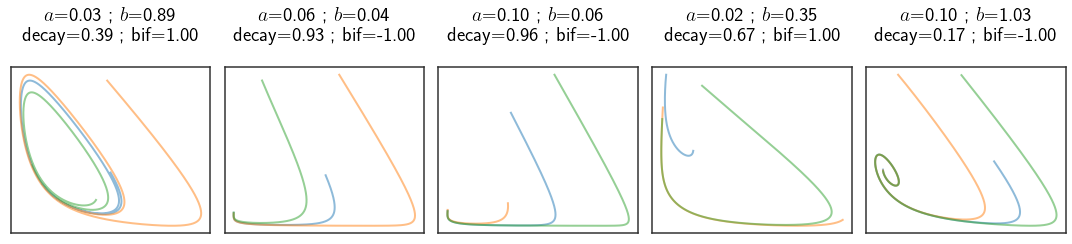

In [66]:
def plot_traj(inits: torch.Tensor, system: PhaseSpace, T: float=40):
    traj = system.trajectories(inits, T, step=1e-3).detach().numpy()
    for i in range(inits.shape[0]):
        plt.plot(traj[:, i, 0], traj[:, i, 1], lw=2, alpha=.5)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    param_tuples = [[k, system.parameters[k]] for k in system.parameters]
    title_str = ''
    for i in range(len(param_tuples)):
        name = system.param_display[param_tuples[i][0]] if param_tuples[i][0] in list(system.param_display.keys()) else param_tuples[i][0]
        title_str += f'{name}={param_tuples[i][1]:.2f}'
        if not (i+1)%2: title_str+='\n'
        elif i<len(param_tuples)-1: title_str += ' ; '
    plt.title(title_str)

np.random.seed(12)
torch.manual_seed(12)
dim = 2
n_systems = 5
systems = [Selkov() for i in range(n_systems)]

plt.figure(figsize=(3*n_systems, 3.5))
for i in range(n_systems):
    plt.subplot(1, n_systems, i+1)
    plot_traj(torch.rand(3, 2)*4, systems[i], T=10)
plt.tight_layout()
# plt.savefig('graphics/selkov_trajectories.png')
plt.show()

==================== a=0.03 b=0.89 decay=0.39 bif=1.00 


100%|██████████| 2000/2000 [00:54<00:00, 36.66it/s, loss=0.0078; projvar=0.354]


a=-0.25, om=-1.00, score=0.0096, loss=0.0078, ldet=-12.1075


100%|██████████| 2000/2000 [00:54<00:00, 36.69it/s, loss=0.0080; projvar=0.354]


a=0.25, om=-1.00, score=0.0093, loss=0.0080, ldet=-9.9196

predicted=1, true=1 --> correct



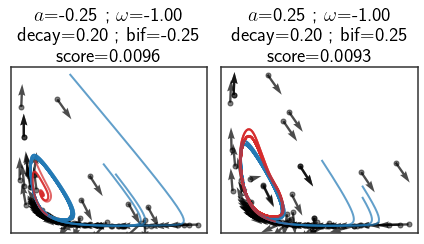

==================== a=0.06 b=0.04 decay=0.93 bif=-1.00 


100%|██████████| 2000/2000 [00:52<00:00, 37.78it/s, loss=0.0121; projvar=0.352]


a=-0.25, om=-1.00, score=0.0176, loss=0.0121, ldet=-9.5269


100%|██████████| 2000/2000 [00:54<00:00, 36.87it/s, loss=0.0111; projvar=0.353]


a=0.25, om=-1.00, score=0.0148, loss=0.0111, ldet=-10.0346

predicted=1, true=-1 --> wrong



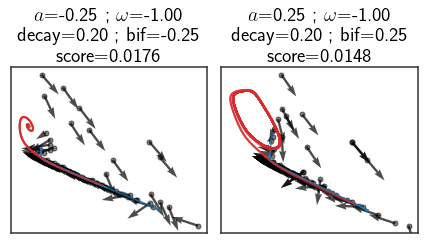

==================== a=0.10 b=0.06 decay=0.96 bif=-1.00 


100%|██████████| 2000/2000 [00:52<00:00, 37.86it/s, loss=0.0046; projvar=0.369]


a=-0.25, om=-1.00, score=0.0046, loss=0.0046, ldet=-11.0434


100%|██████████| 2000/2000 [00:52<00:00, 37.86it/s, loss=0.0046; projvar=0.369]


a=0.25, om=-1.00, score=0.0047, loss=0.0046, ldet=-10.2492

predicted=-1, true=-1 --> correct



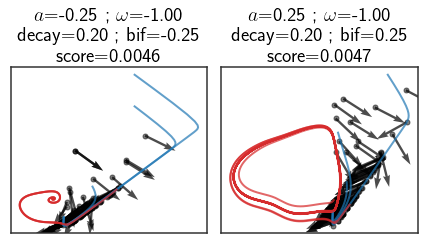

==================== a=0.02 b=0.35 decay=0.67 bif=1.00 


100%|██████████| 2000/2000 [00:53<00:00, 37.40it/s, loss=0.0156; projvar=0.339]


a=-0.25, om=-1.00, score=0.0152, loss=0.0157, ldet=-9.4528


100%|██████████| 2000/2000 [00:53<00:00, 37.70it/s, loss=0.0063; projvar=0.350]


a=0.25, om=-1.00, score=0.0062, loss=0.0063, ldet=-10.2202

predicted=1, true=1 --> correct



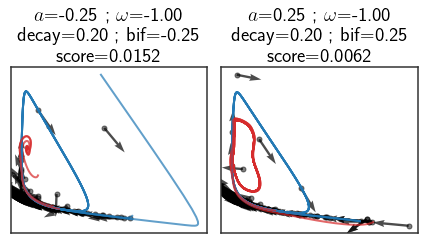

==================== a=0.10 b=1.03 decay=0.17 bif=-1.00 


100%|██████████| 2000/2000 [00:52<00:00, 38.15it/s, loss=0.0083; projvar=0.351]


a=-0.25, om=-1.00, score=0.0033, loss=0.0048, ldet=-12.3743


100%|██████████| 2000/2000 [00:51<00:00, 38.62it/s, loss=0.0101; projvar=0.346]


a=0.25, om=-1.00, score=0.0104, loss=0.0093, ldet=-9.1839

predicted=-1, true=-1 --> correct



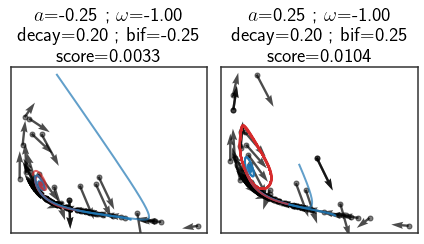

overall accuracy=0.80


In [68]:
def traj_in_vecs(x: torch.Tensor, xdot: torch.Tensor, gt_sys: PhaseSpace, arch: PhaseSpace, H: Diffeo, lims, T: float=40, extra_str: str='', W: torch.Tensor=None):
    inds = np.random.choice(x.shape[0], 3, replace=False)
    gt_traj = gt_sys.trajectories(x[inds], T=T).detach()

    if W is not None: gt_traj = gt_traj@W

    gt_traj = gt_traj.numpy()

    y = H.forward(x[inds]).detach()
    traj = arch.trajectories(y, T=T)
    traj = H.reverse(traj.reshape(-1, traj.shape[-1])).reshape(traj.shape).detach().numpy()
    for i in range(traj.shape[1]):
        plt.plot(gt_traj[:, i, 0], gt_traj[:, i, 1], lw=2, alpha=.7, color='tab:blue')
        plt.plot(traj[:, i, 0], traj[:, i, 1], lw=2, alpha=.7, color='tab:red')

    norms = torch.clamp(torch.norm(xdot, dim=1, keepdim=True), 1)
    xdot = xdot/norms
    inds = np.random.choice(x.shape[0], 75)
    x, xdot = x.detach().numpy()[inds], xdot.detach().numpy()[inds]
    plt.scatter(x[:, 0], x[:, 1], 25, 'k', alpha=.5)
    plt.quiver(x[:, 0], x[:, 1], xdot[:, 0], xdot[:, 1], scale=5, color='k', alpha=.7, width=.012)

    # plt.xlim(lims)
    # plt.ylim(lims)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

    param_tuples = [[k, arch.parameters[k]] for k in arch.parameters]
    title_str = ''
    for i in range(len(param_tuples)):
        name = arch.param_display[param_tuples[i][0]] if param_tuples[i][0] in list(arch.param_display.keys()) else param_tuples[i][0]
        title_str += f'{name}={param_tuples[i][1]:.2f}'
        if not (i+1)%2: title_str+='\n'
        elif i<len(param_tuples)-1: title_str += ' ; '
    plt.title(title_str+extra_str)

archetypes = [
        [-.25, -1, .2],
        [.25, -1, .2],
        # [-.25, .5, .5],
        # [.25, .5, .5]
]

device = 'cpu'

def classify_system(system: PhaseSpace, n_pts: int, T: float, dim: int=3, model_args: dict=dict(), **kwargs):
    init = torch.rand(n_pts, dim)*(system.position_lims[1]-system.position_lims[0]) + system.position_lims[0]
    init[:, 2:] = 1e-2
    x = system.rand_on_traj(init, T=T)
    dx = system.forward(0, x)

    W = None
    if x.shape[-1] > 2:
        W = 2*torch.randn(x.shape[-1], x.shape[-1])
        W = W@W.T + torch.eye(x.shape[-1])*.01
        W = torch.linalg.cholesky(W).T
        x, dx = x@W, dx@W

    x, dx = x.to(device), dx.to(device)
    res_dict = {
        'losses': [],
        'scores': [],
        'ldets': [],
        'params': system.parameters,
        'archetypes': archetypes
    }
    print('='*20, end=' ')
    for p in system.parameters: print(f'{p}={system.parameters[p]:.2f}', end=' ')
    print()

    plt.figure(figsize=(3*len(archetypes), 3.5))
    for i, (a, omega, decay) in enumerate(archetypes):
        archetype = get_oscillator(a=a, omega=omega, decay=decay)
        H = Diffeo(dim=dim, rank=2, **model_args).to(device)
        H, loss, ldet, score = fit_DFORM(H, x.clone().to(device), dx.clone().to(device), archetype, verbose=True, **kwargs)
        res_dict['losses'].append(loss)
        res_dict['scores'].append(score)
        res_dict['ldets'].append(ldet)
        print(f'a={a:.2f}, om={omega:.2f}, score={score:.4f}, loss={loss:.4f}, ldet={ldet:.4f}')

        plt.subplot(1, len(archetypes), i+1)
        traj_in_vecs(x, dx, system, SO(a=a, omega=omega, decay=decay), H, lims=[0, 5], extra_str=f'score={score:.4f}',
                     W=W)

    print('')
    pred = archetypes[np.argmin(res_dict['scores'])][0]
    print(f'predicted={int(np.sign(pred))}, true={np.sign(system.parameters["bif"])} --> '
          f'{"correct" if np.sign(pred)==np.sign(system.parameters["bif"]) else "wrong"}')
    print()
    plt.tight_layout()
    plt.show()
    return res_dict, np.sign(pred), np.sign(system.parameters['bif'])

torch.manual_seed(0)
np.random.seed(0)

model_args = {
    'n_layers': 4,
    'K': 5,
    'add_log': False,
    'actnorm': True,
    'MLP': False,
    'affine_init': True,
}

fit_args = {
    'its': 2000,
    'lr': 1e-3,
    'weight_decay': 1e-3,
    'freeze_frac': .0,
    'dim2_weight': None,
    'proj_reg': -1,
    'test_fr': .0,
}
dim = 4

n_pts = 500
preds, labs = [], []
for sys in systems:
    res, p, l = classify_system(sys, n_pts=n_pts, dim=dim, T=2.5, model_args=model_args, **fit_args)
    preds.append((p+1)/2)
    labs.append((l+1)/2)

preds, labs = np.array(preds), np.array(labs)
print(f'overall accuracy={1-np.mean(np.abs(preds-labs)):.2f}')